In [1]:
import pandas as pd
import utilssphering
import utils
import os
import random
import numpy as np
import itertools
import pycytominer
import matplotlib.pyplot as plt

random.seed(9000)

In [2]:
# Set some variables + read the metadata

n_samples = 1000
n_replicates = 4  #number of sample replicates within each plate 
metadata_common = 'Metadata_moa'
metadata_perturbation = 'Metadata_broad_sample'
group_by_feature = 'Metadata_broad_sample'

experiment_df = (
    pd.read_csv('output/experiment-metadata.tsv', sep='\t')
#    .query('Batch==@batch')
)


In [25]:
### Trying to find cell counts

for a_vendor in experiment_df["Vendor"].unique():
    vendor_data = experiment_df.loc[experiment_df["Vendor"] == a_vendor]
#    print([a_vendor, len(vendor_data)])
    for a_batch in vendor_data["Batch"].unique():
        batch_data = vendor_data.loc[vendor_data["Batch"] == a_batch]
#        print([a_batch, len(batch_data)])
        for a_plate in batch_data["Assay_Plate_Barcode"].unique():
            plate_data = batch_data.loc[batch_data["Assay_Plate_Barcode"] == a_plate]
#            print([a_plate, len(plate_data)])
            plate_df = utils.load_data(a_batch, a_plate, "normalized_negcon.csv.gz")
            cols = plate_df.columns
            # if "Count" in plate_df.columns:
            #     print([i for i in plate_df.columns if "count" in i])

In [71]:
count_keys = {}
sum_cols = []

# load_path = "../jump-scope/profiles/1siteSubSample_Scope1_MolDev_10X/Plate2_PCO_6ch_4site_10XPA/"
load_path = "../jump-scope/profiles/1siteSubSample_Scope1_MolDev_10X/Plate3_PCO_6ch_4site_10XPA_Crest/"

for i in os.listdir(load_path):
    if i.endswith("csv.gz"):
        temp_df = pd.read_csv(os.path.join(load_path, i))
        cols = [i for i in temp_df.columns if "Count" in i]
        for j in cols:
            sum_cols.append(sum([t for t in temp_df[j]]))
        # Zip and then turn nested lists all into one list
        count_sum = [j for i in zip(cols, sum_cols) for j in i]
        count_keys.update({i: count_sum})
        
count_keys


{'Plate3_PCO_6ch_4site_10XPA_Crest_normalized_negcon.csv.gz': ['Metadata_Site_Count',
  382,
  'Metadata_Count_Cells',
  617546,
  'Metadata_Count_CellsSmall',
  617546,
  'Metadata_Count_Cytoplasm',
  617546,
  'Metadata_Count_CytoplasmSmall',
  617546,
  'Metadata_Count_Nuclei',
  617546,
  'Metadata_Count_NucleiSmall',
  617546,
  'Metadata_Object_Count',
  617546],
 'Plate3_PCO_6ch_4site_10XPA_Crest_normalized_feature_select_batch.csv.gz': ['Metadata_Site_Count',
  382,
  'Metadata_Count_Cells',
  617546,
  'Metadata_Count_CellsSmall',
  617546,
  'Metadata_Count_Cytoplasm',
  617546,
  'Metadata_Count_CytoplasmSmall',
  617546,
  'Metadata_Count_Nuclei',
  617546,
  'Metadata_Count_NucleiSmall',
  617546,
  'Metadata_Object_Count',
  617546],
 'Plate3_PCO_6ch_4site_10XPA_Crest_augmented.csv.gz': ['Metadata_Site_Count',
  382,
  'Metadata_Count_Cells',
  617546,
  'Metadata_Count_CellsSmall',
  617546,
  'Metadata_Count_Cytoplasm',
  617546,
  'Metadata_Count_CytoplasmSmall',
  617

In [30]:
# List columns, if you'd like

dire = "../jump-scope/profiles/1siteSubSample_Scope1_MolDev_10X/Plate2_PCO_6ch_4site_10XPA"

for i in os.listdir(dire):
    if i.endswith(".csv.gz"):
        print(i)
        t = pd.read_csv(os.path.join("../jump-scope/profiles/1siteSubSample_Scope1_MolDev_10X/Plate2_PCO_6ch_4site_10XPA", i))
        # pd.read_csv("../jump-scope/profiles/1siteSubSample_Scope1_MolDev_10X/Plate2_PCO_6ch_4site_10XPA/Plate2_PCO_6ch_4site_10XPA_normalized_negcon.csv.gz")
        print([i for i in t.columns if "Metadata" in i])

# test = pd.read_csv("../jump-scope/profiles/1siteSubSample_Scope1_MolDev_10X/Plate2_PCO_6ch_4site_10XPA/Plate2_PCO_6ch_4site_10XPA.csv.gz")

# [i for i in plate_df.columns if "metadata_" in i.casefold()]

# test

Plate2_PCO_6ch_4site_10XPA_normalized_negcon.csv.gz
['Metadata_broad_sample', 'Metadata_solvent', 'Metadata_Plate', 'Metadata_Well', 'Metadata_Site_Count', 'Metadata_Count_Cells', 'Metadata_Count_CellsSmall', 'Metadata_Count_Cytoplasm', 'Metadata_Count_CytoplasmSmall', 'Metadata_Count_Nuclei', 'Metadata_Count_NucleiSmall', 'Metadata_Object_Count', 'Metadata_InChIKey', 'Metadata_pert_iname', 'Metadata_pubchem_cid', 'Metadata_moa', 'Metadata_pert_type', 'Metadata_control_type', 'Metadata_smiles']
Plate2_PCO_6ch_4site_10XPA.csv.gz
['Metadata_Plate', 'Metadata_Well', 'Metadata_Site_Count', 'Metadata_Count_Cells', 'Metadata_Count_CellsSmall', 'Metadata_Count_Cytoplasm', 'Metadata_Count_CytoplasmSmall', 'Metadata_Count_Nuclei', 'Metadata_Count_NucleiSmall', 'Metadata_Object_Count']
Plate2_PCO_6ch_4site_10XPA_normalized.csv.gz
['Metadata_broad_sample', 'Metadata_solvent', 'Metadata_Plate', 'Metadata_Well', 'Metadata_Site_Count', 'Metadata_Count_Cells', 'Metadata_Count_CellsSmall', 'Metadata_C

In [ ]:
# Original percentage calculations, without sphering

corr_replicating_df = pd.DataFrame()
corr_matching_df = pd.DataFrame()

for a_vendor in experiment_df["Vendor"].unique():
    vendor_data = experiment_df.loc[experiment_df["Vendor"] == a_vendor]
#    print([a_vendor, len(vendor_data)])
    for a_batch in vendor_data["Batch"].unique():
        batch_data = vendor_data.loc[vendor_data["Batch"] == a_batch]
#        print([a_batch, len(batch_data)])
        for a_plate in batch_data["Assay_Plate_Barcode"].unique():
            plate_data = batch_data.loc[batch_data["Assay_Plate_Barcode"] == a_plate]
#            print([a_plate, len(plate_data)])
            plate_df = utils.load_data(a_batch, a_plate, "normalized_feature_select_negcon_batch.csv.gz")
            plate_df = utils.remove_negcon_empty_wells(plate_df)
                
            replicating_corr = list(utils.corr_between_replicates(plate_df, group_by_feature))
            null_replicating = list(utils.corr_between_non_replicates(plate_df, n_samples=n_samples, n_replicates=n_replicates, metadata_compound_name = group_by_feature))

            prop_95_replicating, value_95_replicating = utils.percent_score(null_replicating, replicating_corr, how='right')
            
            corr_replicating_df = corr_replicating_df.append({'Vendor': a_vendor,
                                                              'Batch': a_batch,
                                                              'Assay_Plate_Barcode': a_plate,
                                                              'Replicating':replicating_corr,
                                                              'Null_Replicating':null_replicating,
                                                              'Percent_Replicating':'%.1f'%prop_95_replicating,
                                                              'Value_95':value_95_replicating}, ignore_index=True)
            
            matching_corr = list(utils.corr_between_perturbation_pairs(plate_df, 'Metadata_moa', 'Metadata_broad_sample'))
            null_matching = list(utils.corr_between_perturbation_non_pairs(plate_df, n_samples=n_samples, metadata_common=metadata_common, metadata_perturbation=metadata_perturbation))

            prop_95_matching, value_95_matching = utils.percent_score(null_matching, matching_corr, how='right')

            corr_matching_df = corr_matching_df.append({'Vendor': a_vendor,
                                                        'Batch': a_batch,
                                                        'Assay_Plate_Barcode': a_plate,
                                                        'Matching':matching_corr,
                                                        'Null_Matching':null_matching,
                                                        'Percent_Matching':'%.3f'%prop_95_matching,
                                                        'Value_95':value_95_matching}, ignore_index=True)

In [ ]:
# Reload any changes in packages (eg. utilssphering)
%load_ext autoreload
%autoreload 2

### Adding sphering
corr_replicating_df_sphere = pd.DataFrame()
corr_matching_df_sphere = pd.DataFrame()

for a_vendor in experiment_df["Vendor"].unique():
    vendor_data = experiment_df.loc[experiment_df["Vendor"] == a_vendor]
    for a_batch in vendor_data["Batch"].unique():
        batch_data = vendor_data.loc[vendor_data["Batch"] == a_batch]
        for a_plate in batch_data["Assay_Plate_Barcode"].unique():
            plate_data = batch_data.loc[batch_data["Assay_Plate_Barcode"] == a_plate]
            data_path = os.path.join("../jump-scope/profiles/", a_batch, a_plate, a_plate+"_normalized_feature_select_negcon_batch.csv.gz")
            load_data = pd.read_csv(data_path)

            # This works
            replicate_corr, null_corr, prop_95_replicating, value_95_replicating = utilssphering.calculate_percent_replicating_MOA("", "", data_df=load_data)

            matching_corr, matching_null_cor, prop_95_matching, value_95_matching = utilssphering.calculate_percent_matching_MOA("", "", data_df=load_data)
            
            corr_replicating_df_sphere = corr_replicating_df_sphere.append({'Vendor': a_vendor,
                                                              'Batch': a_batch,
                                                              'Assay_Plate_Barcode': a_plate,
                                                              'Replicating':replicate_corr,
                                                              'Null_Replicating':null_corr,
                                                              'Percent_Replicating':'%.1f'%prop_95_replicating,
                                                              'Value_95':value_95_replicating}, ignore_index=True)

            corr_matching_df_sphere = corr_matching_df_sphere.append({'Vendor': a_vendor,
                                                        'Batch': a_batch,
                                                        'Assay_Plate_Barcode': a_plate,
                                                        'Matching':matching_corr,
                                                        'Null_Matching':matching_null_cor,
                                                        'Percent_Matching':'%.3f'%prop_95_matching,
                                                        'Value_95':value_95_matching}, ignore_index=True)

/var/folders/rw/691cc6h16f9cfxlh9g6bpq400000gq/T/ipykernel_13840/1916382909.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_replicating_df = corr_replicating_df.append({'Vendor': a_vendor,
/var/folders/rw/691cc6h16f9cfxlh9g6bpq400000gq/T/ipykernel_13840/1916382909.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_replicating_df = corr_replicating_df.append({'Vendor': a_vendor,
/var/folders/rw/691cc6h16f9cfxlh9g6bpq400000gq/T/ipykernel_13840/1916382909.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_matching_df = corr_matching_df.append({'Vendor': a_vendor,
/var/folders/rw/691cc6h16f9cfxlh9g6bpq400000gq/T/ipykernel_13840/1916382909.py:74: FutureWarning: The frame.append method is deprecated and wi

KeyboardInterrupt: 

In [33]:
def create_moa_dataframe(experiment_metadata, profile_parent_dir, match_or_rep_or_both="replicating", enable_sphering="both"):
    n_samples = 1000
    n_replicates = 4  #number of sample replicates within each plate 
    metadata_common = 'Metadata_moa'
    metadata_perturbation = 'Metadata_broad_sample'
    group_by_feature = 'Metadata_broad_sample'

    corr_replicating_list = list()
    corr_matching_list = list()

    for ind, a_vendor in enumerate(experiment_metadata["Vendor"].unique()):
        vendor_data = experiment_metadata.loc[experiment_metadata["Vendor"] == a_vendor]
        for a_batch in vendor_data["Batch"].unique():
            batch_data = vendor_data.loc[vendor_data["Batch"] == a_batch]
            for a_plate in batch_data["Assay_Plate_Barcode"].unique():
                # plate_data = batch_data.loc[batch_data["Assay_Plate_Barcode"] == a_plate]
                data_path = os.path.join(profile_parent_dir, a_batch, a_plate, a_plate+"_normalized_feature_select_negcon_batch.csv.gz")
                load_data = pd.read_csv(data_path)
            
                if match_or_rep_or_both.casefold() == "replicating" or match_or_rep_or_both.casefold() == "both":
                    if enable_sphering == "yes" or enable_sphering.casefold() == "both":
                        sphere_bool = True
                        replicate_corr_sphere, null_replicating_sphere, prop_95_replicating_sphere, value_95_replicating_sphere = utilssphering.calculate_percent_replicating_MOA("", "", data_df=load_data)
                        corr_replicating_list.append(pd.DataFrame({'Vendor': a_vendor,
                                                                        'Batch': a_batch,
                                                                        'Assay_Plate_Barcode': a_plate,
                                                                        # 'Replicating':replicate_corr_sphere,
                                                                        # 'Null_Replicating':null_replicating_sphere,
                                                                        'Percent_Replicating':prop_95_replicating_sphere,
                                                                        'Value_95':value_95_replicating_sphere,
                                                                        'sphering': sphere_bool}, index=[ind]))

                    if enable_sphering == "no" or enable_sphering.casefold() == "both": 
                        sphere_bool = False
                        # The below functions are integrated into the calculate_percent_replicating_MOA used above
                        plate_df = utils.load_data(a_batch, a_plate, "normalized_feature_select_negcon_batch.csv.gz")
                        plate_df = utils.remove_negcon_empty_wells(plate_df)
                        replicate_corr = list(utils.corr_between_replicates(plate_df, group_by_feature))
                        null_replicating = list(utils.corr_between_non_replicates(plate_df, n_samples=n_samples, n_replicates=n_replicates, metadata_compound_name=group_by_feature))

                        prop_95_replicating, value_95_replicating = utils.percent_score(null_replicating, replicate_corr, how='right')
                        corr_replicating_list.append(pd.DataFrame({'Vendor': a_vendor,
                                                                        'Batch': a_batch,
                                                                        'Assay_Plate_Barcode': a_plate,
                                                                        # 'Replicating':replicate_corr,
                                                                        # 'Null_Replicating':null_replicating,
                                                                        'Percent_Replicating':prop_95_replicating,
                                                                        'Value_95':value_95_replicating,
                                                                        'sphering': sphere_bool}, index=[ind]))

                if match_or_rep_or_both.casefold() == "matching" or match_or_rep_or_both.casefold() == "both":
                    if enable_sphering == "yes" or enable_sphering.casefold() == "both":
                        sphere_bool = True
                        matching_corr_sphere, null_matching_sphere, prop_95_matching_sphere, value_95_matching_sphere = utilssphering.calculate_percent_matching_MOA("", "", data_df=load_data)

                        corr_matching_list.append(pd.DataFrame({'Vendor': a_vendor,
                                                                    'Batch': a_batch,
                                                                    'Assay_Plate_Barcode': a_plate,
                                                                    # 'Matching':matching_corr_sphere,
                                                                    # 'Null_Matching':null_matching_sphere,
                                                                    'Percent_Matching':prop_95_matching_sphere,
                                                                    'Value_95':value_95_matching_sphere,
                                                                    'sphering': sphere_bool}, index=[ind]))
                    
                    if enable_sphering == "no" or enable_sphering.casefold() == "both": 
                        sphere_bool = False
                        plate_df = utils.load_data(a_batch, a_plate, "normalized_feature_select_negcon_batch.csv.gz")
                        plate_df = utils.remove_negcon_empty_wells(plate_df)
                        matching_corr = list(utils.corr_between_perturbation_pairs(plate_df, 'Metadata_moa', 'Metadata_broad_sample'))
                        null_matching = list(utils.corr_between_perturbation_non_pairs(plate_df, n_samples=n_samples, metadata_common=metadata_common, metadata_perturbation=metadata_perturbation))

                        prop_95_matching, value_95_matching = utils.percent_score(null_matching, matching_corr, how='right')

                        corr_matching_list.append(pd.DataFrame({'Vendor': a_vendor,
                                                                    'Batch': a_batch,
                                                                    'Assay_Plate_Barcode': a_plate,
                                                                    # 'Matching':matching_corr,
                                                                    # 'Null_Matching':null_matching,
                                                                    'Percent_Matching':prop_95_matching,
                                                                    'Value_95':value_95_matching,
                                                                    'sphering': sphere_bool}, index=[ind]))

    # Concatenate the data
    if match_or_rep_or_both.casefold() == "replicating" or match_or_rep_or_both.casefold() == "both":
        corr_replicating_df = pd.concat(corr_replicating_list, ignore_index=True)
    if match_or_rep_or_both.casefold() == "matching" or match_or_rep_or_both.casefold() == "both":
        corr_matching_df = pd.concat(corr_matching_list, ignore_index=True)
                
    # Merge metadata with output dataframes
    merge_columns = ['Vendor', 'Batch', 'Assay_Plate_Barcode']
    if match_or_rep_or_both.casefold() == "both":
        corr_replicating_df = experiment_metadata.merge(corr_replicating_df, how="inner", on=merge_columns)
        corr_matching_df = experiment_metadata.merge(corr_matching_df, how="inner", on=merge_columns)
        return corr_replicating_df, corr_matching_df
    if match_or_rep_or_both.casefold() == "replicating":
        return experiment_metadata.merge(corr_replicating_df, how="inner", on=merge_columns)
    elif match_or_rep_or_both.casefold() == "matching":
        return experiment_metadata.merge(corr_matching_df, how="inner", on=merge_columns)

df = create_moa_dataframe(pd.read_csv('output/experiment-metadata.tsv', sep='\t'), "../jump-scope/profiles/", match_or_rep_or_both="replicating", enable_sphering="no")

df



,Vendor,Batch,Plate_Map_Name,Assay_Plate_Barcode,Modality,spinning-disc,Binning,Magnification,aperture,dry-immersion,Number_of_channels,Images_per_well,z_plane,BF_Zplanes,Anomaly,Percent_Replicating,Value_95,sphering
0,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Confocal,no,1.0,10.0,0.45,NaN,6.0,4.0,1.0,NaN,none,38.888889,0.390623,False
1,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,yes,1.0,10.0,0.45,NaN,6.0,4.0,1.0,NaN,none,50.000000,0.302196,False
2,MolDev,Scope1_MolDev_10X_4siteZ,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crestz,Confocal,yes,1.0,10.0,0.45,NaN,6.0,4.0,3.0,NaN,none,53.333333,0.291444,False
3,MolDev,Scope1_MolDev_20X_4site,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_20XPA_Crestz,Confocal,yes,1.0,20.0,0.75,NaN,6.0,4.0,3.0,NaN,none,43.333333,0.304240,False
4,MolDev,Scope1_MolDev_20X_9site,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_9site_20XPA,Confocal,no,1.0,20.0,0.75,NaN,6.0,9.0,1.0,NaN,none,56.666667,0.260286,False
5,MolDev,Scope1_MolDev_20X_9site,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_9site_20XPA_Crest,Confocal,yes,1.0,20.0,0.75,NaN,6.0,9.0,1.0,NaN,none,50.000000,0.357763,False
6,MolDev,Scope1_MolDev_20X_Adaptive,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_Adaptive_20XPA,Confocal,yes,1.0,20.0,0.75,NaN,6.0,3.0,1.0,NaN,none,22.222222,0.595078,False
7,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,NaN,1.0,10.0,0.45,NaN,4.0,1.0,1.0,NaN,none,28.888889,0.410282,False
8,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117061a10x,Widefield,NaN,1.0,10.0,0.45,NaN,4.0,1.0,1.0,NaN,none,39.772727,0.348310,False
9,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117062a10x,Widefield,NaN,1.0,10.0,0.45,NaN,4.0,1.0,1.0,NaN,none,27.777778,0.456659,False


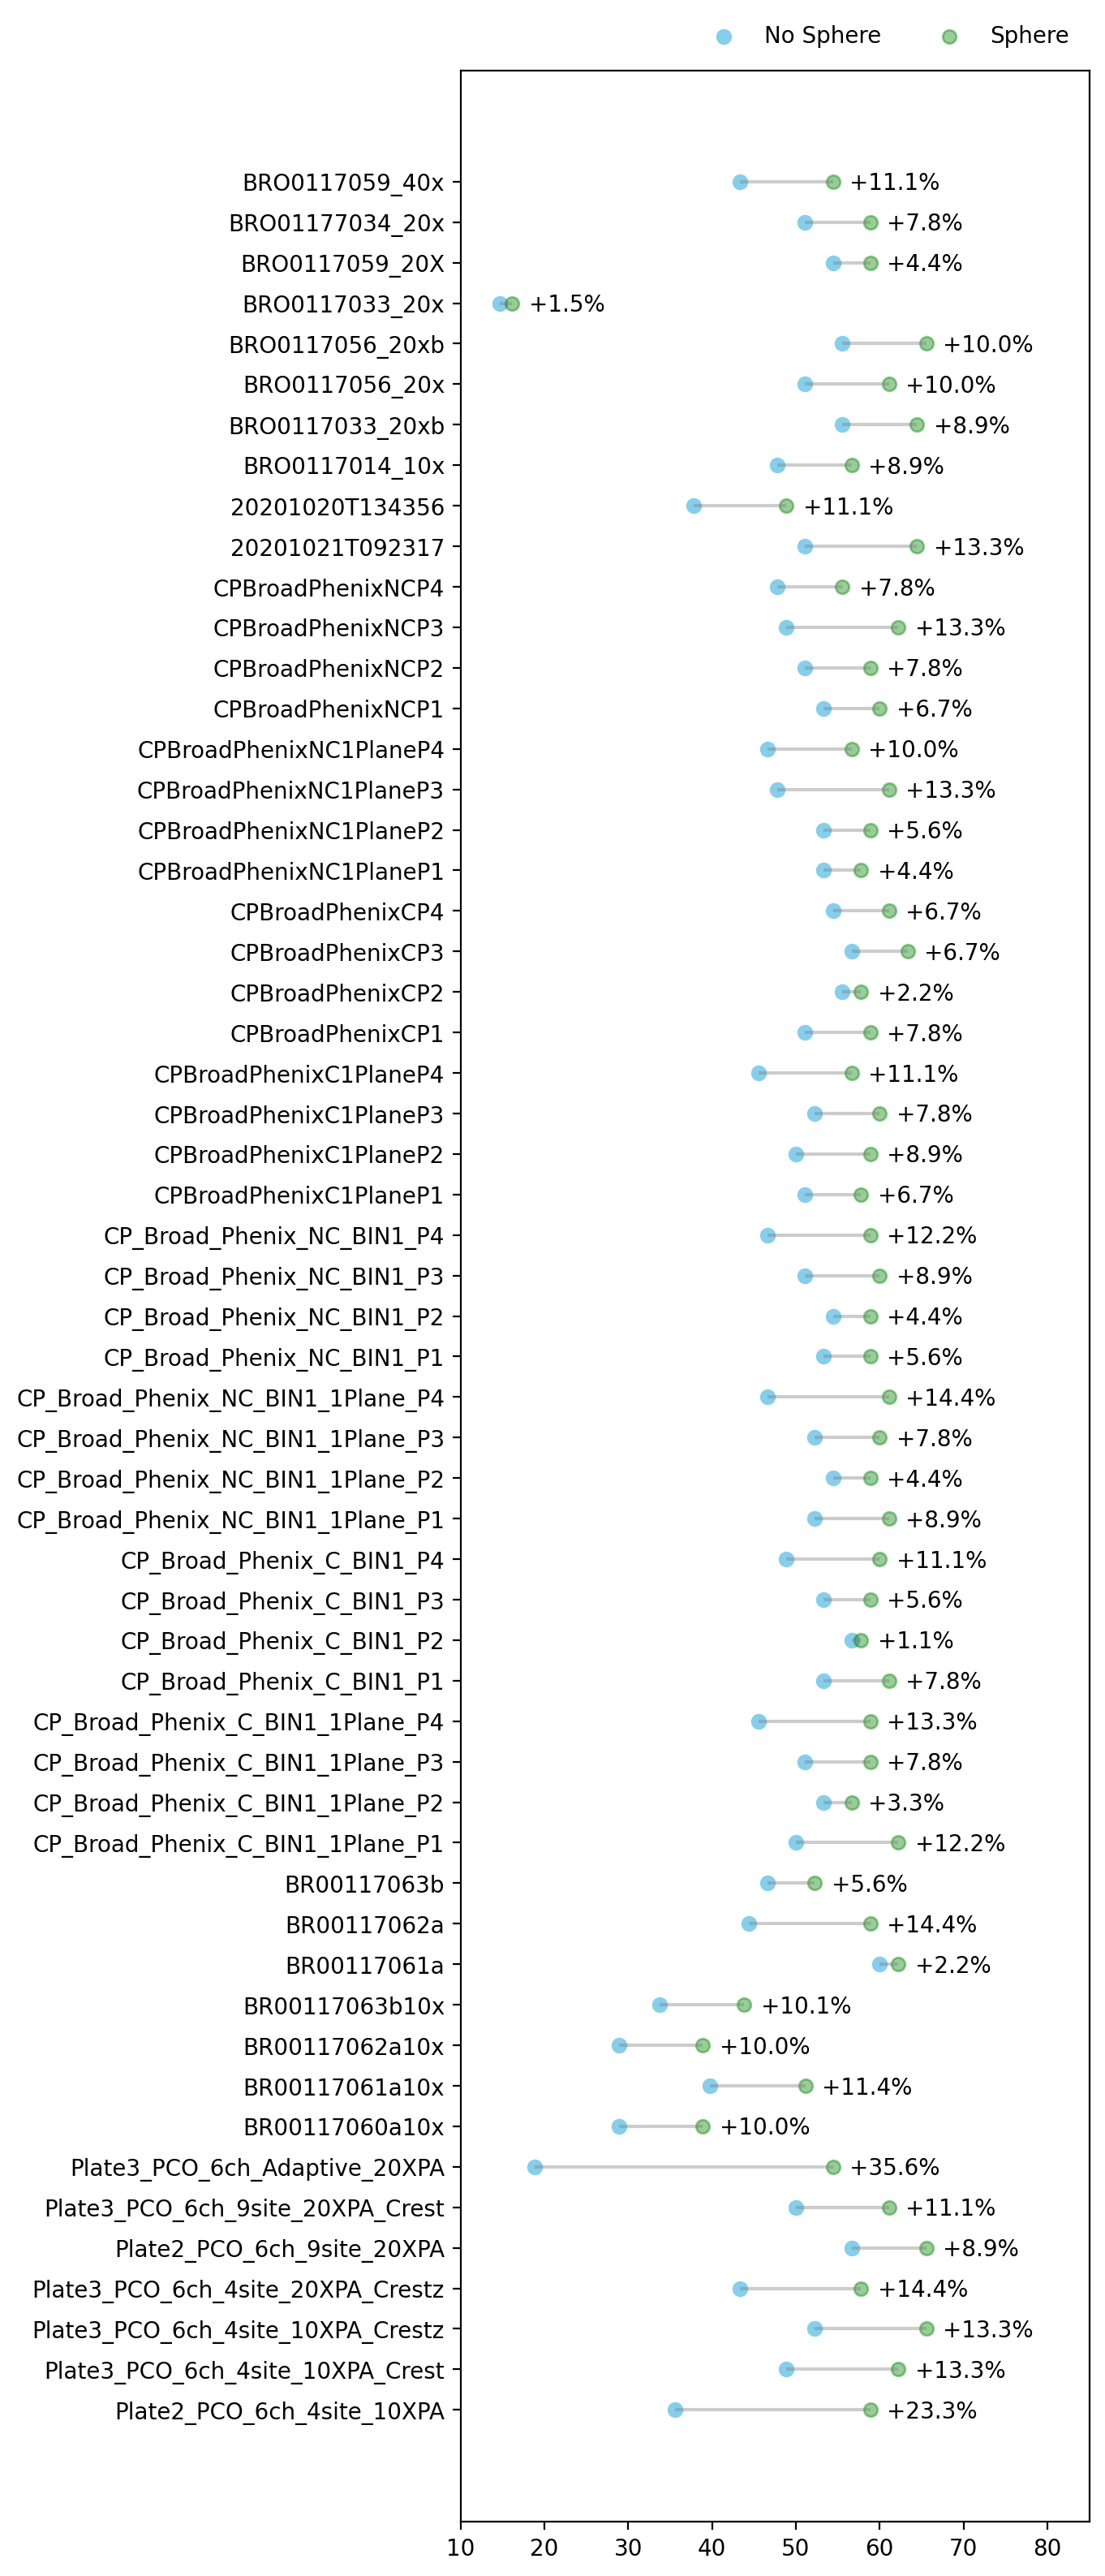

In [32]:
df[df["sphering"]==True]["Assay_Plate_Barcode"]

fig, ax = plt.subplots(figsize=(5, 20), dpi=200)

df_len = df[df["sphering"]==True].shape[0]

ax.set_xlim([10, 85])
ax.hlines(df[df["sphering"]==True]["Assay_Plate_Barcode"], 
        xmin=df[df["sphering"]==False]["Percent_Replicating"].astype(float), 
        xmax=df[df["sphering"]==True]["Percent_Replicating"].astype(float),
        color='grey', alpha=0.4)
ax.scatter(df[df["sphering"]==False]["Percent_Replicating"].astype(float),
        df[df["sphering"]==False]["Assay_Plate_Barcode"],
        color='skyblue', alpha=1,
        label="No Sphere")
ax.scatter(df[df["sphering"]==True]["Percent_Replicating"].astype(float),
        df[df["sphering"]==True]["Assay_Plate_Barcode"],
        color='green', alpha=0.4,
        label="Sphere")
        # Sort=False to maintain order used in ax.hlines
for (_, row), y in zip(df.groupby("Assay_Plate_Barcode", sort=False), range(0, df_len+1)):
        row.loc[row["sphering"]==True]["Percent_Replicating"].iloc[0]
        difference_value = row.loc[row['sphering']==True]['Percent_Replicating'].iloc[0] - row.loc[row['sphering']==False]['Percent_Replicating'].iloc[0]
        plt.annotate(f"+{difference_value:.1f}%", (row.loc[row["sphering"]==True]["Percent_Replicating"].iloc[0]+2, y -0.2))

ax.legend(ncol=2, bbox_to_anchor=(1, 1.001), loc="lower right", frameon=False)
fig.set_facecolor("white")

# fig.savefig("have_no_sphere.png", bbox_inches = 'tight')

In [ ]:
# Find cell counts in various places, just to be sure
count_keys = {}
sum_cols = []

# load_path = "../jump-scope/profiles/1siteSubSample_Scope1_MolDev_10X/Plate2_PCO_6ch_4site_10XPA/"
load_path = "../jump-scope/profiles/1siteSubSample_Scope1_MolDev_10X/Plate3_PCO_6ch_4site_10XPA_Crest/"

for i in os.listdir(load_path):
    if i.endswith("csv.gz"):
        temp_df = pd.read_csv(os.path.join(load_path, i))
        cols = [i for i in temp_df.columns if "Count" in i]
        for j in cols:
            sum_cols.append(sum([t for t in temp_df[j]]))
        # Zip and then turn nested lists all into one list
        count_sum = [j for i in zip(cols, sum_cols) for j in i]
        count_keys.update({i: count_sum})
        
count_keys


{'Plate3_PCO_6ch_4site_10XPA_Crest_normalized_negcon.csv.gz': ['Metadata_Site_Count',
  382,
  'Metadata_Count_Cells',
  617546,
  'Metadata_Count_CellsSmall',
  617546,
  'Metadata_Count_Cytoplasm',
  617546,
  'Metadata_Count_CytoplasmSmall',
  617546,
  'Metadata_Count_Nuclei',
  617546,
  'Metadata_Count_NucleiSmall',
  617546,
  'Metadata_Object_Count',
  617546],
 'Plate3_PCO_6ch_4site_10XPA_Crest_normalized_feature_select_batch.csv.gz': ['Metadata_Site_Count',
  382,
  'Metadata_Count_Cells',
  617546,
  'Metadata_Count_CellsSmall',
  617546,
  'Metadata_Count_Cytoplasm',
  617546,
  'Metadata_Count_CytoplasmSmall',
  617546,
  'Metadata_Count_Nuclei',
  617546,
  'Metadata_Count_NucleiSmall',
  617546,
  'Metadata_Object_Count',
  617546],
 'Plate3_PCO_6ch_4site_10XPA_Crest_augmented.csv.gz': ['Metadata_Site_Count',
  382,
  'Metadata_Count_Cells',
  617546,
  'Metadata_Count_CellsSmall',
  617546,
  'Metadata_Count_Cytoplasm',
  617546,
  'Metadata_Count_CytoplasmSmall',
  617

In [ ]:
# Subset a batch
rep_match_sphere_df.loc[rep_match_sphere_df["Batch"] == "Scope1_MolDev_10X"]


In [28]:
### Creating dropout datasets + matrix

import pycytominer
import pandas as pd
import itertools

def do_feature_select(plate_df):
    """
    Find the column names that are CellProfiler features. Eg. column names
    that start with "Nuclei" or "Cytoplasm"
    """
    feature_select_features = pycytominer.cyto_utils.infer_cp_features(
        plate_df
    )
    # For all of the cellprofiler features, perform these operations on them
    return pycytominer.feature_select(
        profiles=plate_df,
        features=feature_select_features,
        operation=['variance_threshold','correlation_threshold',
        'drop_na_columns','blocklist']
    )

In [ ]:

def all_combo_dropouts_in_a_category(category_list,outfile,subsample=None):
    """
    Create a database with dropped out features

    category_list: the categories to drop out (for example, Nuclei, Cytoplasm, Cells)
    outfile: save csv path
    """
    # For all of the categories, find all possible combinations with itertools.combinations
    to_try = [y for x in range(len(category_list)+1) for y in list(set(itertools.combinations(category_list,x)))]

    # If the output csv already exists, check what dropouts have already been tried
    # Don't try them again
    if os.path.exists(outfile):
        dropout_df = pd.read_csv(outfile)
        tried=list(dropout_df['Dropout'])
        print(f"Already try {tried},skipping")
        to_try = [x for x in to_try if str(x) not in tried]
    # Otherwise, dropout columns will be generated from scratch
    else:
        dropout_df = pd.DataFrame()
    
    # For the given categories, go through each combination (eg. ('Cells', 'Cytoplasm'), ('Nuclei', 'Cytoplasm') etc.)
    for eachdropout in to_try:
        # Get what columns are expected. I don't like this method
        normalized_master = pd.read_csv('../profiles-pilots/profiles/Stain5_CondC_Standard/BR00120274/BR00120274_normalized_negcon.csv.gz')
        col_list = normalized_master.columns
        if subsample:
             for each_item in subsample:
                metadata_list = [x for x in col_list if 'Metadata' in x] 
                col_list = metadata_list+[x for x in col_list if each_item in x]
        for each_item in eachdropout:
            # Create a list of columns that DOESN'T contain the categories being iterated
            # Thus this will iterate over all categories (eg. nuclei, cell, cytoplasm) and
            # drop all of the column names
            col_list = [x for x in col_list if each_item not in x]
        dropout_dict = {}
        temp_dropout_dict = {}
        # Code unique to this dataset. Iterate through plates
        for eachplate in range(70,78):
            try:
                # Read only the columns previously defined for each plate being iterated over
                # Again, don't like this hardcoding. Should be some sort of os.walk situation
                normalized = pandas.read_csv(
                    f'../profiles-pilots/profiles/Stain5_CondC_Standard/BR001202{eachplate}/BR001202{eachplate}_normalized_negcon.csv.gz',
                    usecols=col_list)
                # For the loaded dataset, calculate feature selection AFTER column dropout
                feature_select = do_feature_select(normalized)
                temp_dropout_dict[f'{eachplate}_featnum']=len(feature_select.columns)
                # Now, calculate the perc_rep for the dropout dataset 
                ### NOTE: in utilsphering, calculate_percent_replicating_MOA has been updated to return
                ### replicate_corr, null_corr, prop_95, value_95_replicating
                ### In this example, calculate_percent_replicating_MOA is **only returning prop_95**
                dropout_dict[f'BR001202{eachplate}']= calculate_percent_replicating_MOA('','',data_df=feature_select)
            except:
                dropout_dict[f'BR001202{eachplate}']=0
        # Convert the calculated perc_rep into np.array for each dropout 
        results_array = np.array(list(dropout_dict.values()))
        for k,v in temp_dropout_dict.items():
            dropout_dict[k]=v
        # For the dropout dataset created, calculate the mean perc_replicating for ALL of the plates
        # Why all of the plates? Are these replicates?
        # Means are calculated within each dropout group
        dropout_dict['Mean']=results_array.mean()
        dropout_dict['Median']=np.median(results_array)
        dropout_dict['Standard deviation']=np.std(results_array)
        dropout_dict['Dropout']=eachdropout
        dropout_dict['Remaining'] = [x for x in category_list if x not in eachdropout]
        dropout_dict['n_columns']=len(col_list)
        dropout_df = dropout_df.append(dropout_dict,ignore_index=True)
        print(eachdropout,dropout_dict['Mean'])
        dropout_df.to_csv(outfile,index=False)
    print(dropout_df['Mean'].describe())
    print(dropout_df['Median'].describe())


# all_combo_dropouts_in_a_category(['Nuclei','Cells','Cytoplasm'],
#                                  'checkpoint_csvs/compartment_dropout_combinations.csv')

In [86]:
def category_dropout(dataframe, dataframe_name, category_list, output):
    input_columns = dataframe.columns
    possible_combinations = [y for x in range(len(category_list)+1) for y in list(set(itertools.combinations(category_list,x)))]
    dropout_list = []
    dropout_df = pd.DataFrame()

    # Iterate through the combination to dropout
    for dropout_group in possible_combinations: 
        col_list = input_columns
        # Within the droupout group, find the column to actually drop
        for each_item in dropout_group:
            # Only keep columns that don't contain the dropout
            col_list = [x for x in input_columns if each_item not in x]
            # print(col_list)
        print(dropout_group)
        dropped_dataframe = dataframe[col_list]
        # print(dataframe.shape, dropped_dataframe.shape)
        dropout_dict = {}
        # temp_dropout_dict = {}
        feature_select = do_feature_select(dropped_dataframe)
        dropout_dict[f"{dataframe_name}_num_features"] = len(feature_select.columns)
        _, _, prop_95, _ = utilssphering.calculate_percent_replicating_MOA("", "", feature_select)
        dropout_dict[f"{dataframe_name}_percent_replicating"] = prop_95
        dropout_dict['Dropout']= dropout_group
        dropout_dict['Remaining'] = str([x for x in category_list if x not in dropout_group])
        dropout_dict['n_columns']=len(col_list)
        # print(dropout_dict)
        dropout_df = dropout_df.append(dropout_dict,ignore_index=True)
        
        # dropout_list.append(pd.DataFrame(dropout_dict))
    # dropout_df = pd.concat(dropout_list, ignore_index=True)
    dropout_df.to_csv(output,index=False)

# TODO: Check that this is accurately dropping, integrate with os.walk, integrate with heatmap matrix


In [87]:


load_file = "../jump-scope/profiles/1siteSubSample_Scope1_MolDev_10X/Plate2_PCO_6ch_4site_10XPA/Plate2_PCO_6ch_4site_10XPA_normalized_negcon.csv.gz"

test_data = pd.read_csv(load_file)

category_dropout(test_data, "Plate2_PCO_6ch_4site_10XPA", ['Nuclei'], "test.csv")

# ['Nuclei','Cells','Cytoplasm']


()


/var/folders/rk/g9d_sr9j7078hnwgpzc265mc0000gn/T/ipykernel_10669/2021962140.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dropout_df = dropout_df.append(dropout_dict,ignore_index=True)


('Nuclei',)


/var/folders/rk/g9d_sr9j7078hnwgpzc265mc0000gn/T/ipykernel_10669/2021962140.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dropout_df = dropout_df.append(dropout_dict,ignore_index=True)


In [120]:
# Trying to find method to find assay_plate_barcodes with os.walk

_, parent_folders, _ = next(os.walk("../jump-scope/profiles/"))

batchname_list = []
for i in parent_folders:
    _, subdirs, _ = next(os.walk(f"../jump-scope/profiles/{i}"))
    batchname_list.extend([os.path.join(f"../jump-scope/profiles/{i}/{sub}") for sub in subdirs])
# Why set? Well, it seems that there are profile duplicates within parent_folders
# I assume the original grouping was determined at this point, rather than through 
# reference to some central grouping DataFrame
# print(len(set(batchname_list)))

# print(batchname_list)

unique_batch_names = []
unique_batch_paths = []
for batch_path in batchname_list:
    batch_name = batch_path.split(os.path.sep)[-1]
    if batch_name not in unique_batch_names:
        unique_batch_names.append(batch_name)
        unique_batch_paths.append(batch_path)

print(len(unique_batch_paths))
# print(unique_batch_paths)

# batchname_list[0].split(os.path.sep)[-1]

56
